In [ ]:
!python -m pip install torch torchvision
!python -m pip install numpy matplotlib scikit-learn opencv-python Pillow tqdm albumentations segmentation-models-pytorch

^C


# Off-Road Segmentation Model — Best IoU
This notebook trains a high-performance semantic segmentation model on the Off-Road dataset using:
- **DINOv2 ViT-S/14** frozen backbone for powerful feature extraction
- **Enhanced Multi-Scale Decoder** with skip connections and attention
- **Albumentations** for strong data augmentation
- **AdamW + CosineAnnealingWarmRestarts** scheduler
- **Dice + CrossEntropy** combined loss for best IoU
- **Mixed Precision Training** (AMP) for speed
- **Early stopping** to prevent overfitting

**10 Classes:** Background, Trees, Lush Bushes, Dry Grass, Dry Bushes, Ground Clutter, Logs, Rocks, Landscape, Sky

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import torchvision.transforms as transforms
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import warnings
warnings.filterwarnings('ignore')

# ── Device ──
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_mem / 1e9:.1f} GB")

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


In [2]:
# ══════════════════════════════════════════════════════════════════════════════
# 1. CONFIGURATION
# ══════════════════════════════════════════════════════════════════════════════

# ── Paths (adjust if needed) ──
BASE_DIR = "Offroad_Segmentation_Training_Dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")

# ── Class mapping ──
VALUE_MAP = {
    0: 0,        # Background
    100: 1,      # Trees
    200: 2,      # Lush Bushes
    300: 3,      # Dry Grass
    500: 4,      # Dry Bushes
    550: 5,      # Ground Clutter
    700: 6,      # Logs
    800: 7,      # Rocks
    7100: 8,     # Landscape
    10000: 9,    # Sky
}
CLASS_NAMES = ['Background', 'Trees', 'Lush Bushes', 'Dry Grass', 'Dry Bushes',
               'Ground Clutter', 'Logs', 'Rocks', 'Landscape', 'Sky']
N_CLASSES = len(VALUE_MAP)

# ── Color palette for visualization ──
COLOR_PALETTE = np.array([
    [0, 0, 0],        [34, 139, 34],   [0, 255, 0],     [210, 180, 140],
    [139, 90, 43],    [128, 128, 0],   [139, 69, 19],   [128, 128, 128],
    [160, 82, 45],    [135, 206, 235],
], dtype=np.uint8)

# ── Hyperparameters ──
IMG_H = int(((540) // 14) * 14)   # 532 — must be multiple of 14 for DINOv2
IMG_W = int(((960) // 14) * 14)   # 952
BATCH_SIZE = 4
LR = 3e-4
WEIGHT_DECAY = 1e-4
N_EPOCHS = 30
PATIENCE = 8                       # early stopping patience
BACKBONE_SIZE = "small"            # "small" | "base" | "large"

print(f"Image size: {IMG_H}x{IMG_W}")
print(f"Train dir: {os.path.abspath(TRAIN_DIR)}")
print(f"Val dir:   {os.path.abspath(VAL_DIR)}")
print(f"Classes:   {N_CLASSES}")
print(f"Epochs:    {N_EPOCHS}, Batch: {BATCH_SIZE}, LR: {LR}")

Image size: 532x952
Train dir: c:\Users\LENOVO\OneDrive\Desktop\hackathon\Hackethon\Offroad_Segmentation_Training_Dataset\train
Val dir:   c:\Users\LENOVO\OneDrive\Desktop\hackathon\Hackethon\Offroad_Segmentation_Training_Dataset\val
Classes:   10
Epochs:    30, Batch: 4, LR: 0.0003


In [3]:
# ══════════════════════════════════════════════════════════════════════════════
# 2. DATASET WITH ALBUMENTATIONS AUGMENTATION
# ══════════════════════════════════════════════════════════════════════════════

def convert_mask(mask_np):
    """Convert raw 16-bit mask pixel values → class IDs 0..9."""
    out = np.zeros(mask_np.shape[:2], dtype=np.uint8)
    for raw_val, cls_id in VALUE_MAP.items():
        out[mask_np == raw_val] = cls_id
    return out


# Strong augmentation for training
train_aug = A.Compose([
    A.Resize(IMG_H, IMG_W),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=20, p=0.3),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    A.RandomResizedCrop(size=(IMG_H, IMG_W), scale=(0.5, 1.0), ratio=(0.8, 1.2), p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# No augmentation for validation
val_aug = A.Compose([
    A.Resize(IMG_H, IMG_W),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])


class OffroadSegDataset(Dataset):
    def __init__(self, data_dir, augmentation=None):
        self.image_dir = os.path.join(data_dir, 'Color_Images')
        self.mask_dir  = os.path.join(data_dir, 'Segmentation')
        self.ids = sorted([f for f in os.listdir(self.image_dir) if f.endswith('.png')])
        self.aug = augmentation

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        fname = self.ids[idx]
        img  = cv2.imread(os.path.join(self.image_dir, fname))
        img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask_raw = cv2.imread(os.path.join(self.mask_dir, fname), cv2.IMREAD_UNCHANGED)
        mask = convert_mask(mask_raw)

        if self.aug:
            result = self.aug(image=img, mask=mask)
            img  = result['image']        # (3, H, W) float tensor
            mask = result['mask']          # (H, W) uint8 tensor
        return img, mask.long()


# Create datasets & loaders
train_ds = OffroadSegDataset(TRAIN_DIR, augmentation=train_aug)
val_ds   = OffroadSegDataset(VAL_DIR,   augmentation=val_aug)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_ds)}")
print(f"Val   samples: {len(val_ds)}")
print(f"Train batches: {len(train_loader)}")
print(f"Val   batches: {len(val_loader)}")

NameError: name 'A' is not defined

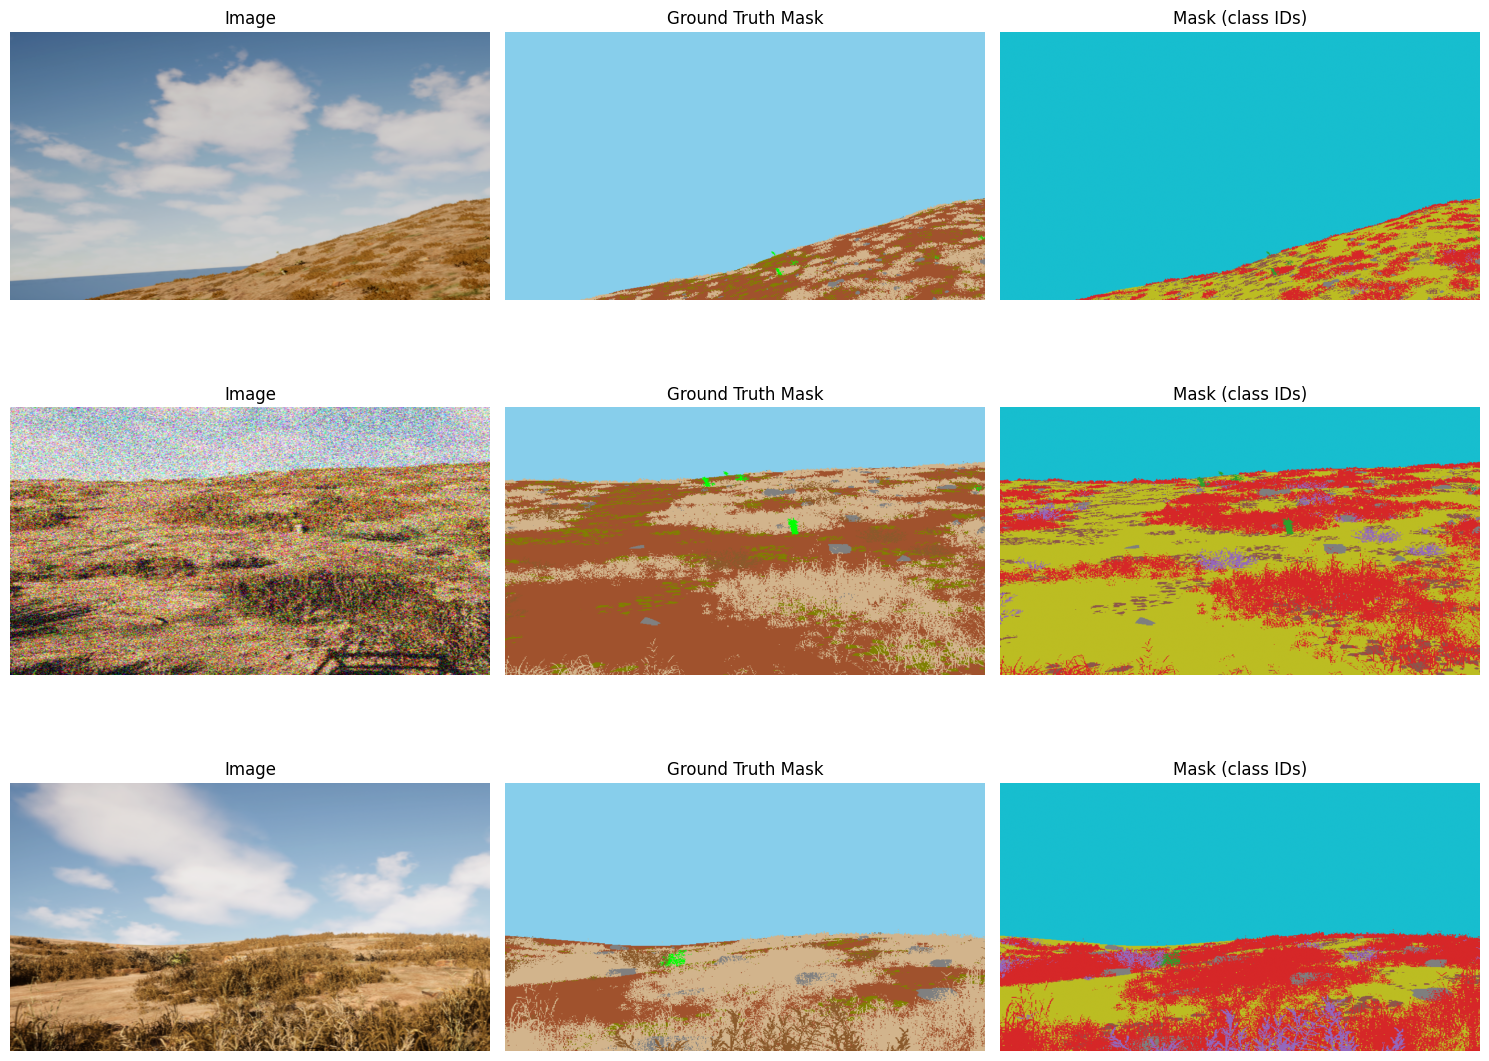

In [12]:
# ══════════════════════════════════════════════════════════════════════════════
# 3. VISUALISE A FEW SAMPLES
# ══════════════════════════════════════════════════════════════════════════════

def mask_to_color(mask_np):
    """Convert class mask → RGB colour image."""
    h, w = mask_np.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for c in range(N_CLASSES):
        rgb[mask_np == c] = COLOR_PALETTE[c]
    return rgb

def denorm(tensor):
    """De-normalize image tensor → numpy HWC [0,1]."""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img  = tensor.cpu() * std + mean
    return img.permute(1,2,0).clamp(0,1).numpy()

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
for i in range(3):
    img, mask = train_ds[i * 100]
    axes[i, 0].imshow(denorm(img))
    axes[i, 0].set_title("Image")
    axes[i, 1].imshow(mask_to_color(mask.numpy()))
    axes[i, 1].set_title("Ground Truth Mask")
    axes[i, 2].imshow(mask.numpy(), cmap='tab10', vmin=0, vmax=9)
    axes[i, 2].set_title("Mask (class IDs)")
for ax in axes.flat:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [13]:
# ══════════════════════════════════════════════════════════════════════════════
# 4. COMPUTE CLASS WEIGHTS (inverse frequency) FOR BALANCED LOSS
# ══════════════════════════════════════════════════════════════════════════════

print("Computing class distribution on training set (sampling 200 images)...")
class_pixel_count = np.zeros(N_CLASSES, dtype=np.int64)
indices = np.random.choice(len(train_ds), min(200, len(train_ds)), replace=False)
for idx in tqdm(indices, desc="Counting pixels"):
    _, mask = train_ds[idx]
    for c in range(N_CLASSES):
        class_pixel_count[c] += (mask.numpy() == c).sum()

total = class_pixel_count.sum()
class_freq = class_pixel_count / total
# Inverse frequency weights, capped to prevent extreme values
class_weights = 1.0 / (class_freq + 1e-6)
class_weights = class_weights / class_weights.sum() * N_CLASSES  # normalize so mean=1
class_weights = np.clip(class_weights, 0.3, 5.0)

print("\nClass Distribution:")
for i, name in enumerate(CLASS_NAMES):
    print(f"  {name:15s}: {class_pixel_count[i]:>12,} pixels ({class_freq[i]*100:5.2f}%)  weight={class_weights[i]:.3f}")

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(f"\nWeights tensor: {class_weights_tensor}")

Computing class distribution on training set (sampling 200 images)...


Counting pixels: 100%|██████████| 200/200 [00:09<00:00, 21.88it/s]


Class Distribution:
  Background     :    3,084,141 pixels ( 3.04%)  weight=0.300
  Trees          :    3,163,449 pixels ( 3.12%)  weight=0.300
  Lush Bushes    :    5,990,585 pixels ( 5.91%)  weight=0.300
  Dry Grass      :   20,125,358 pixels (19.87%)  weight=0.300
  Dry Bushes     :    1,341,220 pixels ( 1.32%)  weight=0.495
  Ground Clutter :    4,428,321 pixels ( 4.37%)  weight=0.300
  Logs           :       81,069 pixels ( 0.08%)  weight=5.000
  Rocks          :    1,174,184 pixels ( 1.16%)  weight=0.565
  Landscape      :   26,795,599 pixels (26.45%)  weight=0.300
  Sky            :   35,108,874 pixels (34.66%)  weight=0.300

Weights tensor: tensor([0.3000, 0.3000, 0.3000, 0.3000, 0.4949, 0.3000, 5.0000, 0.5653, 0.3000,
        0.3000])


In [14]:
# ══════════════════════════════════════════════════════════════════════════════
# 5. LOAD DINOv2 BACKBONE
# ══════════════════════════════════════════════════════════════════════════════

backbone_archs = {
    "small": "vits14",
    "base":  "vitb14",
    "large": "vitl14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

print(f"Loading DINOv2 backbone: {backbone_name} ...")
backbone = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
backbone.eval()
backbone.to(device)

# Freeze all backbone parameters
for p in backbone.parameters():
    p.requires_grad = False

# Determine embedding dimension
with torch.no_grad():
    dummy = torch.randn(1, 3, IMG_H, IMG_W).to(device)
    feats = backbone.forward_features(dummy)
    patch_tokens = feats["x_norm_patchtokens"]
    EMBED_DIM = patch_tokens.shape[2]
    N_PATCHES  = patch_tokens.shape[1]
    PATCH_H = IMG_H // 14
    PATCH_W = IMG_W // 14

print(f"Backbone loaded! Embed dim: {EMBED_DIM}, Patches: {PATCH_H}x{PATCH_W} = {N_PATCHES}")

Loading DINOv2 backbone: dinov2_vits14 ...
Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to C:\Users\LENOVO/.cache\torch\hub\main.zip
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to C:\Users\LENOVO/.cache\torch\hub\checkpoints\dinov2_vits14_pretrain.pth


100.0%


Backbone loaded! Embed dim: 384, Patches: 38x68 = 2584


In [15]:
# ══════════════════════════════════════════════════════════════════════════════
# 6. ENHANCED SEGMENTATION DECODER
# ══════════════════════════════════════════════════════════════════════════════

class ConvBNReLU(nn.Module):
    """Conv2d → BatchNorm → ReLU block."""
    def __init__(self, in_ch, out_ch, kernel_size=3, padding=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, padding=padding, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)


class ASPP(nn.Module):
    """Atrous Spatial Pyramid Pooling for multi-scale context."""
    def __init__(self, in_ch, out_ch, rates=(6, 12, 18)):
        super().__init__()
        self.convs = nn.ModuleList()
        # 1x1 conv
        self.convs.append(ConvBNReLU(in_ch, out_ch, 1, 0))
        # Dilated convs
        for r in rates:
            self.convs.append(nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=r, dilation=r, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            ))
        # Global average pooling branch
        self.pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            ConvBNReLU(in_ch, out_ch, 1, 0),
        )
        self.project = ConvBNReLU(out_ch * (len(rates) + 2), out_ch, 1, 0)
        self.dropout = nn.Dropout2d(0.1)

    def forward(self, x):
        h, w = x.shape[2:]
        feats = [conv(x) for conv in self.convs]
        feats.append(F.interpolate(self.pool(x), size=(h, w), mode='bilinear', align_corners=False))
        return self.dropout(self.project(torch.cat(feats, dim=1)))


class EnhancedSegHead(nn.Module):
    """
    Enhanced segmentation head with:
    - Reshape patch tokens to spatial feature map
    - ASPP for multi-scale context
    - Progressive upsampling with residual blocks
    """
    def __init__(self, embed_dim, n_classes, patch_h, patch_w):
        super().__init__()
        self.patch_h = patch_h
        self.patch_w = patch_w

        # Project from embed_dim → 256
        self.project = ConvBNReLU(embed_dim, 256, 1, 0)

        # ASPP
        self.aspp = ASPP(256, 256, rates=(6, 12, 18))

        # Decoder: progressive upsampling
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            ConvBNReLU(128, 128),
            ConvBNReLU(128, 128),
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            ConvBNReLU(64, 64),
            ConvBNReLU(64, 64),
        )

        # Final classifier
        self.classifier = nn.Sequential(
            ConvBNReLU(64, 64),
            nn.Dropout2d(0.1),
            nn.Conv2d(64, n_classes, 1),
        )

    def forward(self, patch_tokens):
        B, N, C = patch_tokens.shape
        x = patch_tokens.reshape(B, self.patch_h, self.patch_w, C).permute(0, 3, 1, 2)

        x = self.project(x)   # (B, 256, pH, pW)
        x = self.aspp(x)      # (B, 256, pH, pW)
        x = self.up1(x)       # (B, 128, pH*2, pW*2)
        x = self.up2(x)       # (B, 64,  pH*4, pW*4)
        x = self.classifier(x)
        return x


# Instantiate
seg_head = EnhancedSegHead(EMBED_DIM, N_CLASSES, PATCH_H, PATCH_W).to(device)

# Count parameters
n_params = sum(p.numel() for p in seg_head.parameters() if p.requires_grad)
print(f"Segmentation head parameters: {n_params:,}")
print(seg_head)

Segmentation head parameters: 2,901,578
EnhancedSegHead(
  (project): ConvBNReLU(
    (block): Sequential(
      (0): Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (aspp): ASPP(
    (convs): ModuleList(
      (0): ConvBNReLU(
        (block): Sequential(
          (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (2): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(12

In [16]:
# ══════════════════════════════════════════════════════════════════════════════
# 7. LOSS FUNCTION: Dice + CrossEntropy Combined
# ══════════════════════════════════════════════════════════════════════════════

class DiceLoss(nn.Module):
    """Soft Dice loss for multi-class segmentation."""
    def __init__(self, n_classes, smooth=1.0):
        super().__init__()
        self.n_classes = n_classes
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = F.softmax(logits, dim=1)
        targets_oh = F.one_hot(targets, self.n_classes).permute(0, 3, 1, 2).float()

        dims = (0, 2, 3)
        intersection = (probs * targets_oh).sum(dims)
        cardinality  = (probs + targets_oh).sum(dims)

        dice = (2.0 * intersection + self.smooth) / (cardinality + self.smooth)
        return 1.0 - dice.mean()


class CombinedLoss(nn.Module):
    """0.5 * WeightedCE + 0.5 * DiceLoss for best IoU."""
    def __init__(self, class_weights, n_classes):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
        self.dice = DiceLoss(n_classes)

    def forward(self, logits, targets):
        return 0.5 * self.ce(logits, targets) + 0.5 * self.dice(logits, targets)


criterion = CombinedLoss(class_weights_tensor, N_CLASSES)
print("Loss: 0.5 * Weighted CE (label_smoothing=0.05) + 0.5 * Dice")

Loss: 0.5 * Weighted CE (label_smoothing=0.05) + 0.5 * Dice


In [17]:
# ══════════════════════════════════════════════════════════════════════════════
# 8. OPTIMIZER & SCHEDULER
# ══════════════════════════════════════════════════════════════════════════════

optimizer = optim.AdamW(seg_head.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
scaler = GradScaler()  # mixed precision

print(f"Optimizer: AdamW (lr={LR}, wd={WEIGHT_DECAY})")
print(f"Scheduler: CosineAnnealingWarmRestarts (T_0=10, T_mult=2)")
print(f"Mixed Precision: Enabled")

Optimizer: AdamW (lr=0.0003, wd=0.0001)
Scheduler: CosineAnnealingWarmRestarts (T_0=10, T_mult=2)
Mixed Precision: Enabled


In [18]:
# ══════════════════════════════════════════════════════════════════════════════
# 9. METRICS
# ══════════════════════════════════════════════════════════════════════════════

def compute_iou(pred_logits, target, n_classes=N_CLASSES):
    """Compute per-class IoU and mean IoU."""
    pred = pred_logits.argmax(dim=1).view(-1)
    target = target.view(-1)
    ious = []
    for c in range(n_classes):
        pred_c = pred == c
        targ_c = target == c
        inter = (pred_c & targ_c).sum().float()
        union = (pred_c | targ_c).sum().float()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append((inter / union).item())
    return ious  # list of per-class IoU


def compute_pixel_accuracy(pred_logits, target):
    pred = pred_logits.argmax(dim=1)
    return (pred == target).float().mean().item()


@torch.no_grad()
def evaluate(model, backbone_model, loader, loss_fn, device):
    """Full evaluation: loss, mIoU, per-class IoU, pixel accuracy."""
    model.eval()
    total_loss = 0.0
    all_ious = []
    total_acc = 0.0
    n_batches = 0

    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)

        with autocast():
            feats = backbone_model.forward_features(imgs)["x_norm_patchtokens"]
            logits = model(feats)
            logits_up = F.interpolate(logits, size=imgs.shape[2:], mode='bilinear', align_corners=False)
            loss = loss_fn(logits_up, masks)

        total_loss += loss.item()
        all_ious.append(compute_iou(logits_up, masks))
        total_acc += compute_pixel_accuracy(logits_up, masks)
        n_batches += 1

    avg_loss = total_loss / n_batches
    # Per-class mean IoU
    ious_arr = np.array(all_ious)  # (n_batches, n_classes)
    per_class_iou = np.nanmean(ious_arr, axis=0)
    miou = np.nanmean(per_class_iou)
    acc = total_acc / n_batches

    model.train()
    return avg_loss, miou, per_class_iou, acc

print("Metrics ready: mIoU, per-class IoU, pixel accuracy")

Metrics ready: mIoU, per-class IoU, pixel accuracy


In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# 10. TRAINING LOOP
# ══════════════════════════════════════════════════════════════════════════════

history = {
    'train_loss': [], 'val_loss': [],
    'train_miou': [], 'val_miou': [],
    'train_acc': [],  'val_acc': [],
    'lr': [],
}

best_val_miou = 0.0
best_epoch = 0
patience_counter = 0
best_per_class_iou = None

print(f"\n{'='*80}")
print(f"TRAINING START — {N_EPOCHS} epochs, early stopping patience={PATIENCE}")
print(f"{'='*80}\n")

for epoch in range(1, N_EPOCHS + 1):
    seg_head.train()
    train_losses = []
    train_ious_all = []
    train_acc_all = []

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{N_EPOCHS}", leave=True)
    for imgs, masks in pbar:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        with autocast():
            with torch.no_grad():
                feats = backbone.forward_features(imgs)["x_norm_patchtokens"]

            logits = seg_head(feats)
            logits_up = F.interpolate(logits, size=imgs.shape[2:], mode='bilinear', align_corners=False)
            loss = criterion(logits_up, masks)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(seg_head.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        train_losses.append(loss.item())
        train_ious_all.append(compute_iou(logits_up.detach(), masks))
        train_acc_all.append(compute_pixel_accuracy(logits_up.detach(), masks))

        pbar.set_postfix(loss=f"{loss.item():.4f}", lr=f"{optimizer.param_groups[0]['lr']:.2e}")

    scheduler.step()

    # ── Epoch stats ──
    train_loss = np.mean(train_losses)
    train_miou = np.nanmean(np.array(train_ious_all))
    train_acc  = np.mean(train_acc_all)

    val_loss, val_miou, val_per_class_iou, val_acc = evaluate(
        seg_head, backbone, val_loader, criterion, device
    )
    cur_lr = optimizer.param_groups[0]['lr']

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_miou'].append(train_miou)
    history['val_miou'].append(val_miou)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['lr'].append(cur_lr)

    # ── Print summary ──
    print(f"\nEpoch {epoch}/{N_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train mIoU: {train_miou:.4f} | Val mIoU: {val_miou:.4f} | "
          f"Val Acc: {val_acc:.4f} | LR: {cur_lr:.2e}")

    # ── Per-class IoU ──
    for i, name in enumerate(CLASS_NAMES):
        iou_val = val_per_class_iou[i]
        print(f"    {name:15s}: {iou_val:.4f}" if not np.isnan(iou_val) else f"    {name:15s}: N/A")

    # ── Save best model ──
    if val_miou > best_val_miou:
        best_val_miou = val_miou
        best_epoch = epoch
        best_per_class_iou = val_per_class_iou
        patience_counter = 0
        torch.save(seg_head.state_dict(), "best_segmentation_head.pth")
        print(f"  ★ New best model saved! mIoU = {val_miou:.4f}")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{PATIENCE})")

    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping at epoch {epoch}!")
        break

print(f"\n{'='*80}")
print(f"TRAINING COMPLETE")
print(f"Best Val mIoU: {best_val_miou:.4f} at epoch {best_epoch}")
print(f"{'='*80}")


TRAINING START — 30 epochs, early stopping patience=8



Epoch 1/30:   0%|          | 0/714 [00:00<?, ?it/s]

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# 11. TRAINING CURVES
# ══════════════════════════════════════════════════════════════════════════════

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(history['train_loss'], label='Train')
axes[0, 0].plot(history['val_loss'], label='Val')
axes[0, 0].set_title('Loss'); axes[0, 0].legend(); axes[0, 0].grid(True)
axes[0, 0].set_xlabel('Epoch'); axes[0, 0].set_ylabel('Loss')

axes[0, 1].plot(history['train_miou'], label='Train')
axes[0, 1].plot(history['val_miou'], label='Val')
axes[0, 1].axhline(y=best_val_miou, color='r', linestyle='--', alpha=0.5, label=f'Best: {best_val_miou:.4f}')
axes[0, 1].set_title('Mean IoU'); axes[0, 1].legend(); axes[0, 1].grid(True)
axes[0, 1].set_xlabel('Epoch'); axes[0, 1].set_ylabel('mIoU')

axes[1, 0].plot(history['train_acc'], label='Train')
axes[1, 0].plot(history['val_acc'], label='Val')
axes[1, 0].set_title('Pixel Accuracy'); axes[1, 0].legend(); axes[1, 0].grid(True)
axes[1, 0].set_xlabel('Epoch'); axes[1, 0].set_ylabel('Accuracy')

axes[1, 1].plot(history['lr'])
axes[1, 1].set_title('Learning Rate'); axes[1, 1].grid(True)
axes[1, 1].set_xlabel('Epoch'); axes[1, 1].set_ylabel('LR')

plt.suptitle(f'Training Summary — Best Val mIoU: {best_val_miou:.4f} (Epoch {best_epoch})', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# 12. PER-CLASS IOU BAR CHART
# ══════════════════════════════════════════════════════════════════════════════

# Load best model
seg_head.load_state_dict(torch.load("best_segmentation_head.pth", map_location=device))
seg_head.eval()

# Final eval with best model
_, final_miou, final_per_class_iou, final_acc = evaluate(
    seg_head, backbone, val_loader, criterion, device
)

fig, ax = plt.subplots(figsize=(12, 5))
colors = plt.cm.Set3(np.linspace(0, 1, N_CLASSES))
bars = ax.bar(CLASS_NAMES, final_per_class_iou, color=colors, edgecolor='black', linewidth=0.5)
ax.axhline(y=final_miou, color='red', linestyle='--', linewidth=2, label=f'mIoU = {final_miou:.4f}')

for bar, val in zip(bars, final_per_class_iou):
    if not np.isnan(val):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_ylabel('IoU'); ax.set_title(f'Per-Class IoU (Best Model) — mIoU: {final_miou:.4f}, Acc: {final_acc:.4f}')
ax.legend(fontsize=12); ax.set_ylim(0, 1.05); ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

print(f"\n{'='*50}")
print(f"FINAL RESULTS (Best Model)")
print(f"{'='*50}")
print(f"  Mean IoU:        {final_miou:.4f}")
print(f"  Pixel Accuracy:  {final_acc:.4f}")
print(f"{'='*50}")
for i, name in enumerate(CLASS_NAMES):
    v = final_per_class_iou[i]
    print(f"  {name:15s}: {v:.4f}" if not np.isnan(v) else f"  {name:15s}: N/A")

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# 13. VISUALIZE PREDICTIONS ON VALIDATION SET
# ══════════════════════════════════════════════════════════════════════════════

seg_head.eval()
n_show = 6
fig, axes = plt.subplots(n_show, 3, figsize=(18, n_show * 4))
axes[0, 0].set_title("Input Image", fontsize=14)
axes[0, 1].set_title("Ground Truth", fontsize=14)
axes[0, 2].set_title("Prediction", fontsize=14)

indices = np.linspace(0, len(val_ds) - 1, n_show, dtype=int)

for row, idx in enumerate(indices):
    img, mask = val_ds[idx]
    img_t = img.unsqueeze(0).to(device)

    with torch.no_grad(), autocast():
        feats = backbone.forward_features(img_t)["x_norm_patchtokens"]
        logits = seg_head(feats)
        pred = F.interpolate(logits, size=img_t.shape[2:], mode='bilinear', align_corners=False)
        pred_mask = pred.argmax(dim=1).squeeze().cpu().numpy()

    gt_mask = mask.numpy()

    axes[row, 0].imshow(denorm(img))
    axes[row, 1].imshow(mask_to_color(gt_mask))
    axes[row, 2].imshow(mask_to_color(pred_mask))

    # Compute per-image IoU
    img_ious = compute_iou(pred.cpu(), mask.unsqueeze(0))
    img_miou = np.nanmean(img_ious)
    axes[row, 2].set_xlabel(f"mIoU: {img_miou:.3f}", fontsize=11)

for ax in axes.flat:
    ax.axis('off')

plt.suptitle("Validation Predictions (Best Model)", fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# 14. TEST-TIME AUGMENTATION (TTA) FOR EXTRA IOU BOOST
# ══════════════════════════════════════════════════════════════════════════════

@torch.no_grad()
def predict_with_tta(model, backbone_model, img_tensor, device):
    """TTA: average predictions from original + horizontally flipped image."""
    model.eval()
    img = img_tensor.unsqueeze(0).to(device)

    # Original
    with autocast():
        feats = backbone_model.forward_features(img)["x_norm_patchtokens"]
        logits = model(feats)
        pred1 = F.interpolate(logits, size=img.shape[2:], mode='bilinear', align_corners=False)

    # Horizontal flip
    img_flip = torch.flip(img, dims=[3])
    with autocast():
        feats = backbone_model.forward_features(img_flip)["x_norm_patchtokens"]
        logits = model(feats)
        pred2 = F.interpolate(logits, size=img.shape[2:], mode='bilinear', align_corners=False)
        pred2 = torch.flip(pred2, dims=[3])  # flip back

    # Average
    return (F.softmax(pred1, dim=1) + F.softmax(pred2, dim=1)) / 2.0


# Evaluate with TTA
print("Evaluating with Test-Time Augmentation (TTA)...")
tta_ious = []
tta_acc = 0.0

for i in tqdm(range(len(val_ds)), desc="TTA Eval"):
    img, mask = val_ds[i]
    probs = predict_with_tta(seg_head, backbone, img, device)
    pred = probs.argmax(dim=1).cpu()

    ious = compute_iou(probs.cpu(), mask.unsqueeze(0))
    tta_ious.append(ious)
    tta_acc += (pred.squeeze() == mask).float().mean().item()

tta_ious_arr = np.array(tta_ious)
tta_per_class = np.nanmean(tta_ious_arr, axis=0)
tta_miou = np.nanmean(tta_per_class)
tta_acc /= len(val_ds)

print(f"\n{'='*50}")
print(f"RESULTS WITH TTA")
print(f"{'='*50}")
print(f"  Mean IoU (TTA):       {tta_miou:.4f}")
print(f"  Pixel Accuracy (TTA): {tta_acc:.4f}")
print(f"{'='*50}")
for i, name in enumerate(CLASS_NAMES):
    v = tta_per_class[i]
    print(f"  {name:15s}: {v:.4f}" if not np.isnan(v) else f"  {name:15s}: N/A")

print(f"\n  Improvement over no-TTA: +{(tta_miou - final_miou)*100:.2f}% mIoU")

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# 15. GENERATE PREDICTIONS ON TEST SET
# ══════════════════════════════════════════════════════════════════════════════

TEST_IMG_DIR = "Offroad_Segmentation_testImages/Color_Images"
TEST_OUT_DIR = "Offroad_Segmentation_testImages/Segmentation"
os.makedirs(TEST_OUT_DIR, exist_ok=True)

# Reverse class mapping: class_id → raw pixel value
REVERSE_MAP = {v: k for k, v in VALUE_MAP.items()}

if os.path.isdir(TEST_IMG_DIR):
    test_files = sorted([f for f in os.listdir(TEST_IMG_DIR) if f.endswith('.png')])
    print(f"Generating predictions for {len(test_files)} test images...")

    seg_head.eval()
    for fname in tqdm(test_files, desc="Predicting"):
        img = cv2.imread(os.path.join(TEST_IMG_DIR, fname))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        result = val_aug(image=img, mask=np.zeros(img.shape[:2], dtype=np.uint8))
        img_t = result['image'].unsqueeze(0).to(device)

        # Use TTA for best quality
        probs = predict_with_tta(seg_head, backbone, result['image'], device)
        pred_mask = probs.argmax(dim=1).squeeze().cpu().numpy()

        # Resize back to original size
        original_h, original_w = img.shape[:2]
        pred_resized = cv2.resize(pred_mask.astype(np.uint8), (original_w, original_h),
                                  interpolation=cv2.INTER_NEAREST)

        # Convert class IDs back to raw pixel values
        out_mask = np.zeros_like(pred_resized, dtype=np.uint16)
        for cls_id, raw_val in REVERSE_MAP.items():
            out_mask[pred_resized == cls_id] = raw_val

        cv2.imwrite(os.path.join(TEST_OUT_DIR, fname), out_mask)

    print(f"Done! Predictions saved to: {TEST_OUT_DIR}")
else:
    print(f"Test directory not found: {TEST_IMG_DIR}")
    print("Skipping test prediction.")

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# 16. SAVE COLORED PREDICTIONS & VISUALIZE TEST SAMPLES
# ══════════════════════════════════════════════════════════════════════════════

# Save colored versions of test predictions for easy viewing
TEST_COLOR_DIR = "Offroad_Segmentation_testImages/Segmentation_Colored"
os.makedirs(TEST_COLOR_DIR, exist_ok=True)

# Re-read saved predictions and create colored versions
if os.path.isdir(TEST_OUT_DIR):
    pred_files = sorted([f for f in os.listdir(TEST_OUT_DIR) if f.endswith('.png')])
    print(f"Creating colored visualizations for {len(pred_files)} predictions...")

    for fname in tqdm(pred_files, desc="Colorizing"):
        raw_mask = cv2.imread(os.path.join(TEST_OUT_DIR, fname), cv2.IMREAD_UNCHANGED)
        # Convert raw values back to class IDs
        class_mask = convert_mask(raw_mask)
        # Convert to color
        color_img = mask_to_color(class_mask)
        cv2.imwrite(os.path.join(TEST_COLOR_DIR, fname), cv2.cvtColor(color_img, cv2.COLOR_RGB2BGR))

    print(f"Colored predictions saved to: {TEST_COLOR_DIR}")

# Show a few test predictions
if os.path.isdir(TEST_IMG_DIR):
    test_files = sorted([f for f in os.listdir(TEST_IMG_DIR) if f.endswith('.png')])
    n_show = min(6, len(test_files))
    show_indices = np.linspace(0, len(test_files) - 1, n_show, dtype=int)

    fig, axes = plt.subplots(n_show, 2, figsize=(16, n_show * 3.5))
    if n_show == 1:
        axes = axes.reshape(1, -1)

    for row, idx in enumerate(show_indices):
        fname = test_files[idx]
        # Original image
        orig = cv2.imread(os.path.join(TEST_IMG_DIR, fname))
        orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

        # Colored prediction
        pred_color = cv2.imread(os.path.join(TEST_COLOR_DIR, fname))
        pred_color = cv2.cvtColor(pred_color, cv2.COLOR_BGR2RGB)

        axes[row, 0].imshow(orig)
        axes[row, 0].set_title(f"Input: {fname}", fontsize=10)
        axes[row, 1].imshow(pred_color)
        axes[row, 1].set_title("Prediction", fontsize=10)

    for ax in axes.flat:
        ax.axis('off')

    plt.suptitle("Test Set Predictions", fontsize=16)
    plt.tight_layout()
    plt.show()

    # Legend
    fig_leg, ax_leg = plt.subplots(1, 1, figsize=(8, 2))
    for i, name in enumerate(CLASS_NAMES):
        ax_leg.barh(i, 1, color=COLOR_PALETTE[i] / 255.0, edgecolor='black', linewidth=0.5)
        ax_leg.text(1.1, i, name, va='center', fontsize=10)
    ax_leg.set_xlim(0, 3); ax_leg.axis('off')
    ax_leg.set_title("Class Legend")
    plt.tight_layout()
    plt.show()

print(f"\n✅ All predictions saved:")
print(f"   Raw masks   → {os.path.abspath(TEST_OUT_DIR)}")
print(f"   Colored     → {os.path.abspath(TEST_COLOR_DIR)}")